# EMF-Datenbank der Bundesnetzagentur

In [1]:
%matplotlib inline
import json

import pandas as pd
import geopandas as gpd

from shapely.geometry import Point

In [2]:
def to_gpd(df, lat='lat', lng='lng'):
    geometry = [Point(xy) for xy in zip(df[lng], df[lat])]
    crs = {'init': 'epsg:4326'}
    return gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

In [3]:
germany = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
germany = germany[germany['name'] == 'Germany']
germany

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
41,82329758.0,Europe,Germany,DEU,2918000.0,"POLYGON ((9.921906365609232 54.98310415304803,..."


In [4]:
def get_data():
    with open('data/positions.jsonl') as f:
        for line in f:
            yield json.loads(line)


In [5]:
df = pd.DataFrame.from_records(get_data())
df.head()

,antennas,datum,fid,kind,position,standortbescheinigung_nr
0,"[{'height': 4.0, 'hdistance': 1.38, 'type': 'M...",None,526994,GetStandorteFreigabe,"{'fID': 526994, 'Titel': '540776', 'Lat': 47.3...",540776
1,"[{'height': 49.7, 'hdistance': 8.6, 'type': 'M...",23.12.2016,512461,GetStandorteFreigabe,"{'fID': 512461, 'Titel': '540951', 'Lat': 47.3...",540951
2,"[{'height': 7.1, 'hdistance': 5.76, 'type': 'M...",18.05.2015,555419,GetStandorteFreigabe,"{'fID': 555419, 'Titel': '542400', 'Lat': 47.3...",542400
3,"[{'height': 7.0, 'hdistance': 7.33, 'type': 'M...",28.10.2014,512460,GetStandorteFreigabe,"{'fID': 512460, 'Titel': '540950', 'Lat': 47.3...",540950
4,"[{'height': 62.3, 'hdistance': 3.28, 'type': '...",16.09.2011,512843,GetStandorteFreigabe,"{'fID': 512843, 'Titel': '541535', 'Lat': 47.3...",541535


In [6]:
df['kind'].value_counts()

GetStandorteFreigabe    84576
GetMessorte             14601
GetAFuFreigabe             65
Name: kind, dtype: int64

## Amateurfunk Freigaben

In [7]:
afu_df = pd.DataFrame.from_records(df[df['kind'] == 'GetAFuFreigabe']['position'].values)
afu_df.head()

,Lat,Lng,Titel,fID
0,47.781943,12.453611,Die Anzeige erfolgte mit den BNetzA-Auswertung...,210114
1,47.821943,11.188610,Die Anzeige erfolgte mit den BNetzA-Auswertung...,210057
2,47.910277,11.430277,Die Anzeige erfolgte mit den BNetzA-Auswertung...,210037
3,48.039300,10.329170,Die Anzeige erfolgte mit den BNetzA-Auswertung...,200011
4,48.056944,11.270554,Die Anzeige erfolgte mit den BNetzA-Auswertung...,210078


In [8]:
afu_df = to_gpd(afu_df, lat='Lat', lng='Lng')

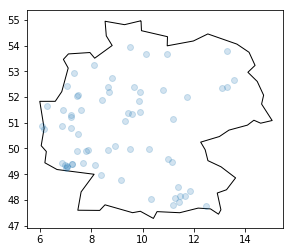

In [9]:
base = germany.plot(color='white', edgecolor='black')
afu_df.plot(ax=base, alpha=0.2)

## Antennen

In [10]:
def get_antennas(df):
    for _, p in df.iterrows():
        if not isinstance(p['antennas'], list):
            continue
        for antenna in p['antennas']:
            antenna['datum'] = p['datum']
            antenna['standortbescheinigung_nr'] = p['standortbescheinigung_nr']
            antenna.update(p['position'])
            yield antenna


In [11]:
a_df = pd.DataFrame.from_records(get_antennas(df[df['kind'] == 'GetStandorteFreigabe']))
a_df['datum'] = pd.to_datetime(a_df['datum'], format='%d.%m.%Y')
a_df.head()

,Lat,Lng,Titel,datum,direction,fID,hdistance,height,sonderseite,standortbescheinigung_nr,type,vdistance
0,47.348333,10.216111,540776,NaT,0,526994,1.38,4,False,540776,Mobilfunk,1.38
1,47.348333,10.216111,540776,NaT,140,526994,0.58,2,False,540776,Mobilfunk,0.58
2,47.348333,10.216111,540776,NaT,48,526994,NaN,6,False,540776,Sonstige Funkanlage,NaN
3,47.350833,10.249166,540951,2016-12-23,150,512461,8.60,49.7,False,540951,Mobilfunk,2.06
4,47.350833,10.249166,540951,2016-12-23,40,512461,8.60,49.7,False,540951,Mobilfunk,2.06


In [12]:
a_df.to_csv('data/antennen.csv', index=False)

In [13]:
ag_df = to_gpd(a_df, lat='Lat', lng='Lng')

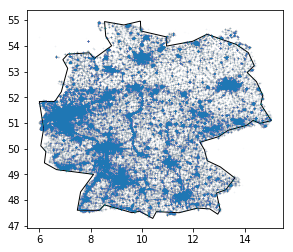

In [14]:
base = germany.plot(color='white', edgecolor='black')
ag_df.plot(ax=base, alpha=0.01, markersize=0.5)